In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import scipy.optimize as op
from scipy.interpolate import UnivariateSpline
import copy 

In [12]:
mnk_fmt = {
        '$\overline{x}$' : "{:.2e}",
        '$\sigma_x^2$'   : "{:.2e}",
        '$\overline{y}$' : "{:.2f}",
        '$\sigma_y^2$'   : "{:.2e}",
        '$r_{xy}$'       : "{:.2e}",
        '$a$'            : "{:.2f}",
        '$\Delta a$'     : "{:.2f}",
        '$b$'            : "{:.2f}",
        '$\Delta b$'     : "{:.2f}",
}

def least_sq(x, y):
    sx = (x**2).mean() - (x.mean())**2
    sy = (y**2).mean() - (y.mean())**2
    rxy = (y*x).mean() - (y.mean() * x.mean())
    a = rxy / sx
    da = (1/(len(x) - 2) * (sy/sx - a**2))**(0.5)
    b = y.mean() - a * x.mean()
    db = da*(sx + (x.mean())**2)**(1/2)
    dat = pd.DataFrame({
        '$\overline{x}$' : [x.mean()],
        '$\sigma_x^2$'   : [sx],
        '$\overline{y}$' : [y.mean()],
        '$\sigma_y^2$'   : [sy],
        '$r_{xy}$'       : [rxy],
        '$a$'            : [a],
        '$\Delta a$'     : [da],
        '$b$'            : [b],
        '$\Delta b$'     : [db],
    })
    
    return dat, [x.mean(), sx, y.mean(), sy, rxy, a, da, b, db]

In [34]:
#
# Creates plot with approximating line
#
# x, y         -- points to plot
# label        -- label of plot in legend
# color        -- color of plot
# xerr, yerr   -- errors of points
# begin, end   -- slice of points to fit approximating line on
# exclude      -- indices of 'error' points
# x_min, x_max -- interval of approximating line
#
# Return:
# x_clean, y_clean -- pd.Series of values used for approximating line
def lin_plot(x, y, label = None, color = None, xerr = 0, yerr = 0,
             begin = 0, end = None, exclude = [],
             x_min = None, x_max = None):
    
    assert len(x) == len(y), "x and y must have same length"
    
    end = len(x) if (end == None) else end
    
    x_clean = []
    y_clean = []
    for i in range(begin, end):
        if i in exclude:
            continue
        x_clean.append(x[i])
        y_clean.append(y[i])
    
    x_min = min(x_clean) if (x_min == None) else x_min
    x_max = max(x_clean) if (x_max == None) else x_max
    
    coeffs = np.polyfit(x_clean, y_clean, 1)
    equ = lambda x: coeffs[0] * x + coeffs[1]
    x_space = np.linspace(x_min, x_max, 100)
    
    p = plt.plot(x_space, equ(x_space), label = label, c = color)
    plt.errorbar(x, y, xerr = xerr, yerr = yerr, fmt = '.', c = p[-1].get_color())
    
    for i in exclude:
        plt.scatter(x[i], y[i], s = 60, marker = 'x', c = 'red')

    return pd.Series(x_clean), pd.Series(y_clean)

## Electromagnet calibration

In [35]:
em_SN = 75 * 10**-4
em_SN

0.007500000000000001

In [36]:
em_data = pd.read_excel("334.ods", engine='odf', usecols = "A:B, D:E", sheet_name = 0)

print(em_data)

   I, A  Phi, mWb  I, A.1  B, mT
0  0.15       0.9    0.15    154
1  0.30       1.7    0.30    280
2  0.45       2.4    0.45    403
3  0.60       3.2    0.60    533
4  0.75       4.0    0.75    653
5  0.90       4.8    0.90    809
6  1.05       5.4    1.05    964
7  1.20       5.9    1.20   1083
8  1.35       6.2    1.35   1145
9  1.50       6.5    1.50   1180


In [37]:
names = [
    ("Webermeter", "I"),
    ("Webermeter", "Phi"),
    ("Magnitometer", "I"),
    ("Magnitometer", "B")
]

em_data.columns = pd.MultiIndex.from_tuples(names)
em_data

Webermeter      Magnitometer      
           I  Phi            I     B
0       0.15  0.9         0.15   154
1       0.30  1.7         0.30   280
2       0.45  2.4         0.45   403
3       0.60  3.2         0.60   533
4       0.75  4.0         0.75   653
5       0.90  4.8         0.90   809
6       1.05  5.4         1.05   964
7       1.20  5.9         1.20  1083
8       1.35  6.2         1.35  1145
9       1.50  6.5         1.50  1180

In [38]:
weber_B = em_data[("Webermeter", "Phi")] / em_SN

em_data.insert(loc=2, column=("Webermeter", "B"), value=weber_B, allow_duplicates=True)
em_data

Webermeter                  Magnitometer      
           I  Phi           B            I     B
0       0.15  0.9  120.000000         0.15   154
1       0.30  1.7  226.666667         0.30   280
2       0.45  2.4  320.000000         0.45   403
3       0.60  3.2  426.666667         0.60   533
4       0.75  4.0  533.333333         0.75   653
5       0.90  4.8  640.000000         0.90   809
6       1.05  5.4  720.000000         1.05   964
7       1.20  5.9  786.666667         1.20  1083
8       1.35  6.2  826.666667         1.35  1145
9       1.50  6.5  866.666667         1.50  1180

In [39]:
names = {
    'Webermeter' : r"Веберметр",
    'Magnitometer' : r"Магнитометр",
    'I' : r"$I$, А",
    'Phi' : r"$\Phi$, Вб",
    'B' : r"$B$, Тл"
}

out_fmt = {
    (names['Webermeter'], names['I']) : "{:.2f}",
    (names['Webermeter'], names['Phi']) : "{:.1f}",
    (names['Webermeter'], names['B']) : "{:.0f}",
    (names['Magnitometer'], names['I']) : "{:.2f}",
    (names['Magnitometer'], names['B']) : "{:.0f}"
}

latex = em_data.rename(
            columns=(names)
        ).style.hide(level=0, axis=0).format(out_fmt, na_rep = "")

latex.to_latex(
            buf = "electromagnet.tex",
            column_format="c" * em_data.shape[1],
            hrules=True,
            multicol_align = 'c',
            environment = ''
        )

latex

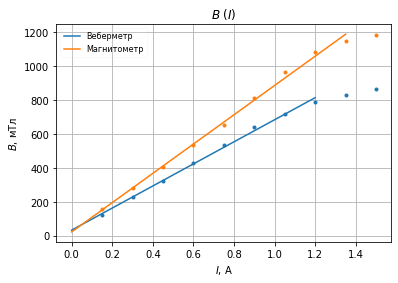

In [42]:
w_I_clean, w_B_clean = lin_plot(em_data[("Webermeter", "I")], em_data[("Webermeter", "B")], "Веберметр",
                                begin = 0, end = 8, x_min = 0)

m_I_clean, m_B_clean = lin_plot(em_data[("Magnitometer", "I")], em_data[("Magnitometer", "B")], "Магнитометр",
                                begin = 0, end = 9, x_min = 0)

plt.title("$B \; (I)$")
plt.ylabel(r"$B$, мТл")
plt.xlabel(r"$I$, А")
plt.grid(True)
plt.legend(fontsize = 8, framealpha = 0.1)
plt.savefig("B_I.pdf")


In [46]:
df, dat = least_sq(w_I_clean, w_B_clean)
latex = df.style.hide(level=0, axis=0).format(mnk_fmt).to_latex()
print(latex)
df

\begin{tabular}{rrrrrrrrr}
$\overline{x}$ & $\sigma_x^2$ & $\overline{y}$ & $\sigma_y^2$ & $r_{xy}$ & $a$ & $\Delta a$ & $b$ & $\Delta b$ \\
6.75e-01 & 1.18e-01 & 471.67 & 5.02e+04 & 7.69e+01 & 650.79 & 16.36 & 32.38 & 12.39 \\
\end{tabular}



,$\overline{x}$,$\sigma_x^2$,$\overline{y}$,$\sigma_y^2$,$r_{xy}$,$a$,$\Delta a$,$b$,$\Delta b$
0,0.675,0.118125,471.666667,50219.444444,76.875,650.793651,16.359391,32.380952,12.391632


## Hall

In [ ]:
def plot_data(data, f, filename):
    a     = np.array([])      # a
    err_a = np.array([])      # errors a

    for i in range(0, len(f)):
        y = data[(str(f[i]), 'L')].dropna() # remove NaNs
        x = data[('f', 'k')][0:len(y)]      # slice x to have the same size as y
        
        df, dat = least_sq(x, y)
        latex = df.style.hide(level=0, axis=0).format(mnk_fmt).to_latex()
        print(latex)

        a     = np.append(a, dat[5])
        err_a = np.append(err_a, dat[6])

        label = r"$f = " + str(f[i]) + r"$ Гц"
        lin_plot_Lk(x, y, label, i)

    plt.title("$L \; (k)$")
    plt.ylabel(r"$L$, мм")
    plt.xlabel(r"$k$")
    plt.grid(True)
    plt.legend(fontsize = 8, framealpha = 0.1)

    print("Coeffs")
    print(a)
    print(err_a)
    plt.savefig(filename)
    
    return a, err_a

In [ ]:
a_air, err_a_air = plot_data(data_air, f_air, "L_k_air.pdf")

In [ ]:
a_carbon, err_a_carbon = plot_data(data_carbon, f_carbon, "L_k_carbon.pdf")

In [ ]:
def print_processed(mu, a, err_a, f, filename):
    lmd = 2 * a
    err_lmd = 2 * err_a

    c = lmd * f / 1000  # mm->m conversion
    print(c)
    err_c = c * ((err_lmd/lmd)**2 + (err_f/f)**2)**0.5
    
    T = 296

    processed = pd.DataFrame({'f'     : f,
                              'a'     : a,   'err_a'       : err_a,
                              'lmd'   : lmd, 'err_lmd'     : err_lmd,
                            })

    names = {
        'f'     : r"$f$, Гц",

        'a'     : r"$a$, мм",
        'err_a' : r"$\sigma_a$, мм",

        'lmd'       : r"$\lambda$, мм",
        'err_lmd'   : r"$\sigma_{\lambda}$, мм",

        'c'     : r"$c$, м/c",
        'err_c' : r"$\sigma_c$, м/с",    
    }

    out_fmt = {
        names['f']     : "{:.0f}",

        names['a']     : "{:.1f}",
        names['err_a'] : "{:.1f}",

        names['lmd']       : "{:.1f}",
        names['err_lmd']   : "{:.1f}",

        names['c']     : "{:.1f}",
        names['err_c'] : "{:.1f}",
    }

    latex = processed.rename(
                columns=(names)
            ).style.hide(level=0, axis=0).format(out_fmt).to_latex(
                buf = filename,
                column_format="c" * len(names),
                hrules=True,
                multicol_align = 'c',
                environment = ''
            )
    
    # Evaluating results
    c_av = np.mean(c)
    err_c_av = 0

    for i in range(len(f)):
        err_c_av += (c[i] - c_av)**2

    err_c_av **= 0.5

    print("c_av:", c_av)
    print(err_c_av)

    gamma_av = mu/(8.31 * T) * c_av**2
    err_gamma_av = gamma_av * ((2 * err_c_av/c_av)**2 + (err_T/T)**2)**0.5

    print("gamma:", gamma_av)
    print(err_gamma_av)


In [ ]:
print_processed(0.029, a_air, err_a_air, f_air, "processed_L_k_air.tex")
print_processed(0.044, a_carbon, err_a_carbon, f_carbon, "processed_L_k_carbon.tex")

## Data F(k)

In [ ]:
data = pd.read_excel("213.ods", engine='odf', usecols = "A, D:E, I:J, N:O, S:T, X:Y, AC:AD", sheet_name = 2)

T = np.array([
    296,
    303,
    308,
    313,
    318,
    323
])
err_T = 0.1

L = 740
err_L = 1

# f_carbon = np.array([])

data

In [ ]:
def rename_cols(data, T):
    tuples = [
        ("T", "k"),
        # (str(f[i]), "l")
        # (str(f[i]), "L") ...
    ]
    for i in range(0, len(T)):
        tuples.append((str(T[i]), "f"))
        tuples.append((str(T[i]), "F"))

    data.columns = pd.MultiIndex.from_tuples(tuples)
    return data

In [ ]:
data = rename_cols(data, T)
data

In [ ]:
def latex_fmt(i, T, names):
    tmp = {
        (str(T[i]), names['f']) : "{:.0f}",
        (str(T[i]), names['F']) : "{:.0f}",
    }
    return tmp

In [ ]:
def print_data(data, T, filename):
    names = {'k' : r"$k$",
             'T' : r"$T, ^{\circ} C$",
             'f' : r"$f$, Гц",
             'F' : r"$F$, Гц"
            }

    out_fmt = {(names['T'], names['k']) : "{:.0f}"}

    for i in range(0, len(T)):
        o_list = latex_fmt(i, T, names)
        out_fmt.update(o_list)

    latex = data.rename(
                columns=(names)
            ).style.hide(level=0, axis=0).format(out_fmt, na_rep = "")

    latex.to_latex(
                buf = filename,
                column_format="c" * data.shape[1],
                hrules=True,
                multicol_align = 'c',
                environment = ''
            )
    return latex

In [ ]:
print_data(data, T, "F_k.tex")

# Process F(k)

In [ ]:
colour = ["red", "blue", "green", "yellow", "purple", "orange"]

def lin_plot(x, y, xerr, yerr, label = None, i = 1):
    coeffs = np.polyfit(x, y, 1)
    equ = lambda x: coeffs[0] * x + coeffs[1]
    
    x_space = np.linspace(min(x), max(x), 100)
    plt.plot(x_space, equ(x_space), label = label, c = colour[i])
    plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='.', c = colour[i])
    

In [ ]:
mnk_fmt = {
        '$\overline{x}$' : "{:.2e}",
        '$\sigma_x^2$'   : "{:.2e}",
        '$\overline{y}$' : "{:.2f}",
        '$\sigma_y^2$'   : "{:.2e}",
        '$r_{xy}$'       : "{:.2e}",
        '$a$'            : "{:.2f}",
        '$\Delta a$'     : "{:.2f}",
        '$b$'            : "{:.2f}",
        '$\Delta b$'     : "{:.2f}",
}

def least_sq(x, y):
    sx = (x**2).mean() - (x.mean())**2
    sy = (y**2).mean() - (y.mean())**2
    rxy = (y*x).mean() - (y.mean() * x.mean())
    a = rxy / sx
    da = (1/(len(x) - 2) * (sy/sx - a**2))**(0.5)
    b = y.mean() - a * x.mean()
    db = da*(sx + (x.mean())**2)**(1/2)
    dat = pd.DataFrame({
        '$\overline{x}$' : [x.mean()],
        '$\sigma_x^2$'   : [sx],
        '$\overline{y}$' : [y.mean()],
        '$\sigma_y^2$'   : [sy],
        '$r_{xy}$'       : [rxy],
        '$a$'            : [a],
        '$\Delta a$'     : [da],
        '$b$'            : [b],
        '$\Delta b$'     : [db],
    })
    
    return dat, [x.mean(), sx, y.mean(), sy, rxy, a, da, b, db]

In [ ]:
def plot_data(data, T, filename):
    a     = np.array([])      # a
    err_a = np.array([])      # errors a

    for i in range(0, len(T)):
        x = 1 / (data[('T', 'k')] + 1)
        y = data[(str(T[i]), 'f')]

        df, dat = least_sq(x, y)
        latex = df.style.hide(level=0, axis=0).format(mnk_fmt).to_latex()
        # print(latex)

        a     = np.append(a, dat[5])
        err_a = np.append(err_a, dat[6])

        label = r"$T = " + str(T[i]) + r"\; K$"
        lin_plot(x, y, 0, 1, label, i)

    plt.title("$F \; (k)$")
    plt.ylabel(r"$F$, Гц")
    plt.xlabel(r"$k$")
    plt.grid(True)
    plt.legend(fontsize = 8, framealpha = 0.1)

    print("Coeffs")
    print(a)
    print(err_a)
    plt.savefig(filename)
    
    return a, err_a

In [ ]:
a, err_a = plot_data(data, T, "F_k.pdf")

In [ ]:
def print_processed(c, c_err, a, a_err, T, filename):
    
    processed = pd.DataFrame({'T'    : T,
                              'a'    : a,     'err_a'     : err_a,
                              'c'    : c,     'err_c'     : err_c,
                              'gamma': gamma, 'err_gamma' : err_gamma
                            })

    names = {
        'T'     : r"$T, \;^{\circ} C$",

        'a'     : r"$a, \; \text{c}^{-1}$",
        'err_a' : r"$\sigma_a, \; \text{c}^{-1}$",

        'c'     : r"$c$, м/c",
        'err_c' : r"$\sigma_c$, м/с",
        
        'gamma' : r"$\gamma$",
        'err_gamma' : r"$\sigma_{\gamma}$"
    }

    out_fmt = {
        names['T']     : "{:.1f}",

        names['a']     : "{:.1f}",
        names['err_a'] : "{:.1f}",

        names['c']     : "{:.1f}",
        names['err_c'] : "{:.1f}",

        names['gamma']     : "{:.3f}",
        names['err_gamma'] : "{:.3f}",
    }

    latex = processed.rename(
                columns=(names)
            ).style.hide(level=0, axis=0).format(out_fmt).to_latex(
                buf = filename,
                column_format="c" * len(names),
                hrules=True,
                multicol_align = 'c',
                environment = ''
            )
    
    # Evaluating results
    gamma_av = np.mean(gamma)
    err_gamma_av = 0

    for i in range(len(T)):
        err_gamma_av += (gamma[i] - gamma_av)**2

    err_gamma_av **= 0.5

    print("gamma_av:", gamma_av)
    print(err_gamma_av)


In [ ]:
c = 2 * a * L / 1000  # mm->m conversion
err_c = c * ((err_a/a)**2 + (err_L/L)**2)**0.5

mu = 0.02898
gamma = mu / (8.31 * T) * c**2
err_gamma = gamma * ((2 * err_c/c)**2 + (err_T/T)**2)**0.5

print_processed(c, err_c, a, err_a, T, "processed_F_k.tex")

In [ ]:
lin_plot(np.sqrt(T), c, err_T/np.sqrt(T), err_c)

plt.title("$c \; (\sqrt{T})$")
plt.ylabel(r"$c$, м/с")
plt.xlabel(r"$\sqrt{T}, \; \sqrt{^{\circ} C}$")
plt.grid(True)
plt.savefig("c_sqrt_T.pdf")
